# Testing the image augmentation library



## Step 0: Dependencies and configuration

Similarly as before, we start by loading useful Python libraries, defining our configuration, and connecting to the AWS SDKs, which will allow us to interface with various AWS services, like Amazon S3 and Amazon SageMaker. 

In [2]:
# generic packages
import os
import json
import shutil
import imageio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
plt.style.use('seaborn')

# AWS-related packages
import boto3  # AWS Python SDK that allows us to interface with all AWS services
import sagemaker  # SageMaker Python SDK that allows us to easily build train and deploy models

In [3]:
sagemaker_role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
boto_session = boto3.session.Session()
region = boto_session.region_name


Again, we will be using the **default bucket** of Amazon SageMaker to store our data, model artifacts and model outputs. 

In [4]:
# variable setup
BUCKET_NAME = sagemaker_session.default_bucket()  # here we will store our data
PREFIX_PROJECT = 'computer-vision-for-retail-workshop'  # main project folder in S3
PREFIX_DATASET = 'dataset-full'  # where our dataset will be located
PREFIX_MODELS = 'models'  # where our trained model weights will be saves
CLASS_NAMES = [  # names of the 10 products that we will be trying to detect
    'flakes',  
    'mm', 
    'coke', 
    'spam', 
    'nutella', 
    'doritos', 
    'ritz', 
    'skittles', 
    'mountaindew', 
    'evian'
]
# print a list of the class names along with their indices
print('Index and class name')
class_indx_names = pd.Series(CLASS_NAMES)
print(class_indx_names,'\n')

MANIFEST_ATTRIBUTE_NAMES = ['source-ref', 'retail-object-labeling']  # attributes to be considered in the manifest files
LOCAL_DATASET_FOLDER = 'dataset'

print('Region:', region)
print('Bucket:', BUCKET_NAME)

# Initialise some empty variables we need to exist:
predictor_std = None
predictor_hpo = None


Index and class name
0         flakes
1             mm
2           coke
3           spam
4        nutella
5        doritos
6           ritz
7       skittles
8    mountaindew
9          evian
dtype: object 

Region: ap-southeast-1
Bucket: sagemaker-ap-southeast-1-482414474587


## Step 1: Explore the image augmentation function

We will be using an image augmentation function `augmentations.py`, located in the `util` folder. The function takes as input an image and generates a set of new images using random transformations, like zooming/unzooming, cropping, sheering, rotation, brightness adjustment, noise, flipping etc. 

Take some time to **explore the impact of each augmentation parameter** in the example below. Here is a quick description for each one. 

| Parameter | Description | Type | Range | Example values and behavior | How to deactivate | 
| --- | --- | --- | --- | --- | --- |
| `how_many` | How many image variations to generate from a single source image | Number | int [0,inf) | e.g. 10 | 0 |
| `random_seed` | A number that controls randomness (for reproducibility) | None or Number| int (-inf, inf) | e.g. 0 | None |
| `range_scale` | Minimum and maximum range for zooming/unzooming on the image | None or Tuple (min,max) | float (0,inf) | <1=zoom in, >1=zoom out, e.g. (0.5,1.5) | None |
| `range_translation` | Minimum and maximum range for offseting the (x,y) position of the image (in pixels) | None or Tuple (min,max) | int [0,inf) | e.g. (-100, 100) | None |
| `range_rotation` | Minimum and maximum range for rotating image left/right (in degrees) | None or Tuple (min,max) | float [-360,360] | e.g.(-45, 45) | None |
| `range_sheer` | Minimum and maximum range for skewing image left/right (in degrees) | None or Tuple (min,max) | float [-360,360] | e.g.(-45, 45) | None |
| `range_noise` | Minimum and maximum range of noise variance | None or Tuple (min,max) | float [0, inf) | e.g. (0, 0.001) | None |
| `range_brightness` | Minimum and maximum range for brightness gain | None or Tuple (min,max) | float (0, inf) | 1=no change, <1=darken, >1=brighten, e.g. (0.5, 1.5) | None |
| `flip_lr` | Flipping image left-right | None or String | None / 'random' / 'all' | If 'all', all images are doubled (flipped + original). If 'random', images are flipped randomly. | None |
| `flip_ud` | Flipping image up-down| None or String | None / 'random' / 'all' | If 'all', all images are doubled (flipped + original). If 'random', images are flipped randomly. | None |
| `bbox_truncate` | Truncate bounding boxes that may end up outside the augmented image| Boolean | False/True | e.g. True | False |
| `bbox_discard_thr` | Percentage of bounding box surface to be located inside the image, in order not to be discarded | Number | float [0,1] | e.g. 0.85 | N/A |
| `display` | Display augmentations or not in the notebook | Boolean | False/True | Use True only for testing! | False |


You need to come up with a *plausible set of variations* and ranges that makes sense for the current use case. For example, flipping the image upside down is not useful in our case, because it is highly unlikely that we will encounter these retail products upside down (particularly for bottles). Additionally, rotating the image too much, will also result in unrealistic images that cannot be encountered in real life.


Augmenting IMG_1599.jpg [x10]


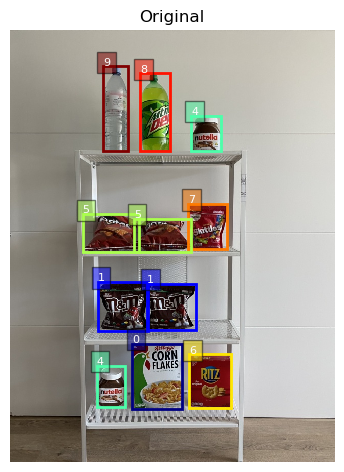


Transformation for augmentation 1
Scale: 1.1616101279454936
Translation_x: 29
Translation_y: 2
Rotation: -2.35444387895373
Sheer: -1.4049209942621397
Noise: 0.0005701967704178797
Brightness: 0.9112787085518639
Enhance: False
Flip left->right:  False
Flip up->down:  False


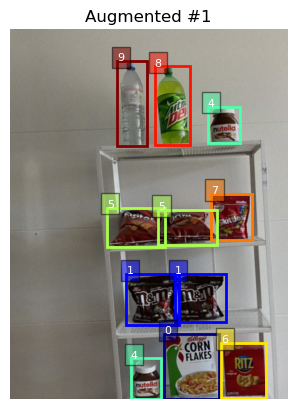


Transformation for augmentation 2
Scale: 1.2863920247793146
Translation_x: 6
Translation_y: 42
Rotation: 2.742336894342166
Sheer: -0.6296804620065855
Noise: 0.00043860151346232035
Brightness: 0.8772625988150137
Enhance: False
Flip left->right:  True
Flip up->down:  False


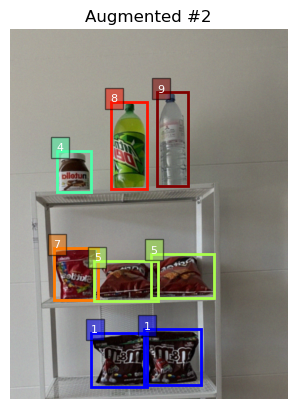


Transformation for augmentation 3
Scale: 1.2020725320537329
Translation_x: -42
Translation_y: -41
Rotation: -0.43849667783451457
Sheer: 1.9763119592726488
Noise: 0.0009883738380592263
Brightness: 1.2594307126256914
Enhance: False
Flip left->right:  False
Flip up->down:  False


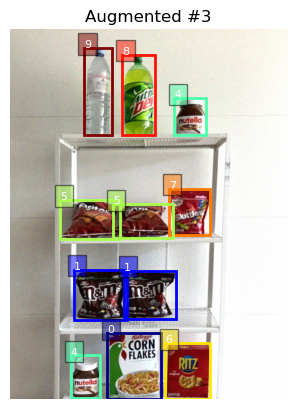


Transformation for augmentation 4
Scale: 1.1586623872476727
Translation_x: -47
Translation_y: 33
Rotation: 0.6843394886864854
Sheer: -4.397745283707302
Noise: 0.00010204481074802807
Brightness: 0.8967280659440298
Enhance: False
Flip left->right:  False
Flip up->down:  False


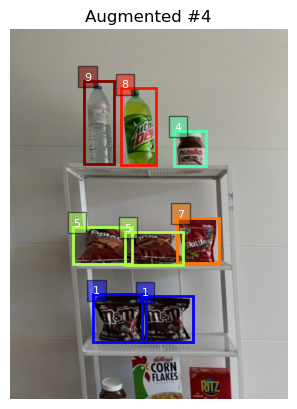


Transformation for augmentation 5
Scale: 1.0677410995041785
Translation_x: 27
Translation_y: 37
Rotation: -4.812101995636449
Sheer: 1.6676671544566766
Noise: 0.0002088767560948347
Brightness: 0.9376076531760374
Enhance: False
Flip left->right:  False
Flip up->down:  False


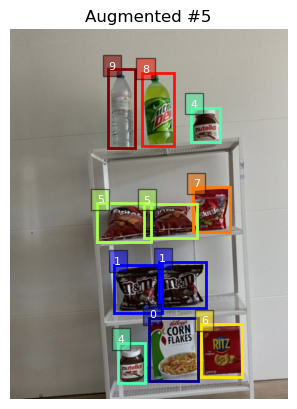


Transformation for augmentation 6
Scale: 1.234420584799992
Translation_x: 47
Translation_y: 29
Rotation: 1.1763549707587708
Sheer: 1.7063786961815939
Noise: 0.00016130951788499625
Brightness: 1.0581076194626748
Enhance: False
Flip left->right:  False
Flip up->down:  False


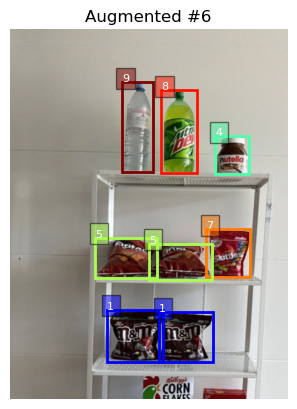


Transformation for augmentation 7
Scale: 1.0781904084470195
Translation_x: -3
Translation_y: 28
Rotation: 1.1209572272242136
Sheer: -2.8961743892615908
Noise: 0.0006531083254653985
Brightness: 1.3746952608935545
Enhance: False
Flip left->right:  True
Flip up->down:  False


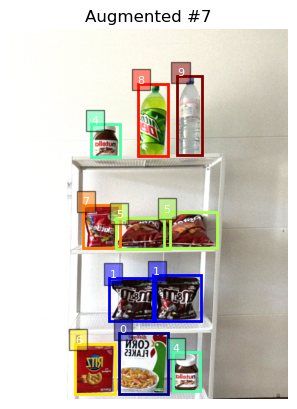


Transformation for augmentation 8
Scale: 1.4188297505865597
Translation_x: -38
Translation_y: 13
Rotation: 1.1693399687475696
Sheer: -3.7107370234514665
Noise: 0.0002532916025397821
Brightness: 0.867970893055143
Enhance: False
Flip left->right:  False
Flip up->down:  False


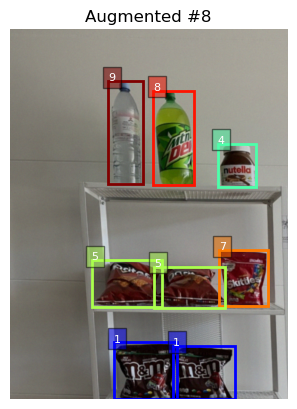


Transformation for augmentation 9
Scale: 1.472747070375772
Translation_x: -35
Translation_y: 44
Rotation: 4.437480785146241
Sheer: -1.8457164907581614
Noise: 0.0004663107728563063
Brightness: 1.3865614352491629
Enhance: False
Flip left->right:  False
Flip up->down:  False


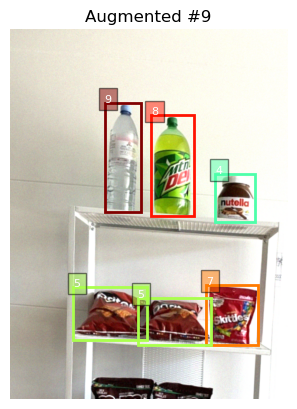


Transformation for augmentation 10
Scale: 1.0375811391193333
Translation_x: 2
Translation_y: -8
Rotation: 1.8182029910348343
Sheer: -1.362892290573774
Noise: 0.00024442559200160273
Brightness: 0.8672688855257742
Enhance: False
Flip left->right:  True
Flip up->down:  False


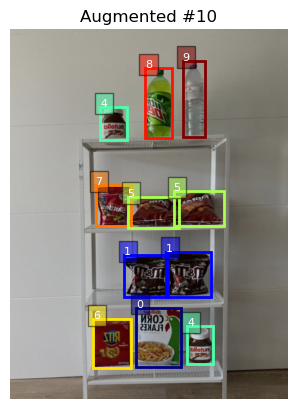

In [2]:
%load_ext autoreload
%autoreload 2

from util.image_augmentator import augment_image

filename = 'images/IMG_1599.jpg'
ls_bboxes = [{"class_id": 4, "top": 169, "left": 357, "height": 70, "width": 59}, {"class_id": 4, "top": 662, "left": 171, "height": 82, "width": 55}, {"class_id": 8, "top": 85, "left": 256, "height": 153, "width": 60}, {"class_id": 9, "top": 71, "left": 183, "height": 167, "width": 49}, {"class_id": 7, "top": 343, "left": 351, "height": 89, "width": 77}, {"class_id": 5, "top": 372, "left": 244, "height": 65, "width": 113}, {"class_id": 5, "top": 363, "left": 143, "height": 74, "width": 112}, {"class_id": 1, "top": 500, "left": 270, "height": 91, "width": 96}, {"class_id": 1, "top": 497, "left": 173, "height": 96, "width": 99}, {"class_id": 0, "top": 619, "left": 241, "height": 128, "width": 99}, {"class_id": 6, "top": 640, "left": 353, "height": 106, "width": 82}]



image_augm = augment_image(
    image_filename=filename,        # the image that will be used as source to generate augmentations
    bboxes =ls_bboxes,              # a list of bounding boxes in the source image
    how_many=10,                    # how many image variations to generate from the source image
    random_seed=0,                  # controls randomness for reproducibility
    range_scale=(0.75, 1.5),        # (mutliplier) minimum and maximum range for zooming/unzooming on the image
    range_translation=(-50, 50),    # (in pixels) minimum and maximum range for offseting the position of the image 
    range_rotation=(-5, 5),         # (in degrees) minimum and maximum range for rotating image left/right.
    range_sheer=(-5, 5),            # (in degrees) minimum and maximum range for skewing image left/right.
    range_noise=(0, 0.001),         # (variance) minimum and maximum range for noise variance
    range_brightness=(0.8, 1.5),    # (mutliplier) minimum and maximum range for brightness gain
    flip_lr='random',               # If None, no left-right flipping is applied. If 'all', all images are flipped. If 'random', images are flipped randomly
    flip_ud=None,                   # same as flip_lr, but for up-down.
    enhance=None,
    bbox_truncate = True,           # truncate bboxes that may end up outside the augmented image.
    bbox_discard_thr = 0.85,        # percentage of bounding box surface to be located inside the image, in order not to be discarded. 
    display=True                    # display augmentations (set as False if you are generating lots of images!!!)
    )
